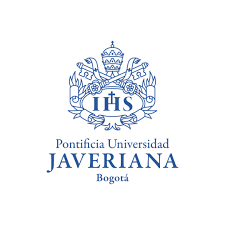
***Pontificia Universidad Javeriana***
# **Procesamiento de Alto Volumen de Datos**

Autor: Federico Quiroga Garcia

Fecha: 5 de abril 2025




**Objetivo**: Uso de MLLIB como Biblioteca IA en PySpark, para la creación de modelos de predicción.

La calidad del agua representa la calidad de vida de los seres humanos. El agua es junto con el aire, las necesidades más importantes para la vida. La definición popular de *calidad del agua son sus características físicas, químicas y biológicas del agua* **[1]**.
 El presente estudio tiene como objetivo el análisis de la calidad del agua en la India, como metodología de trabajo sobre estudios de comportamiento de contaminación y sus modelos en ML para la predicción.

____________________________________________________

In [141]:
## !pip install pyspark
%matplotlib inline
 # Le indicamos a Colab que grafique justo debajo de la celda con el código

In [142]:
# Se importan librerias
import os # Te permite interactuar con el sistema operativo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd # handles maps and shapes in relation to each other
import warnings
warnings.filterwarnings("ignore")

from pylab import *
from pyspark.sql.functions import input_file_name, mean, col, split, regexp_extract, when, lit, isnan, count
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql import SparkSession


In [143]:
# SparkContext crea la conexión principal al motor de Spark
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()
sqlContext = SQLContext(sc)



**Cargar los datos (en la asignación se encuentran los datos a usar)**

In [144]:
## Se conecta con el drive de google, para tener los datos cerca
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [145]:
rutaCSV = "/content/drive/MyDrive/Colab Notebooks/calidad_agua_spark/waterquality.csv"
rutaIndia = "/content/drive/MyDrive/Colab Notebooks/calidad_agua_spark/Indian_States.shp"

# shp es una parte de un conjunto de arhivos que representan un shapefile completo

In [146]:
#Importar OS de Google
os.environ['SHAPE_RESTORE_SHX'] = 'YES'

In [147]:
# Se crea un DataFrame basado en el  archivo csv
df00 = spark.read.csv(rutaCSV, header=True, inferSchema=True)
gpdf00 = gpd.read_file(rutaIndia)

In [148]:
## Se hace inspeccion sobre los datos CSV
df00.show(5)

+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+--------------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|TOTAL_COLIFORM|
+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+--------------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|         735|3.4|                  2|             3|            73|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|  6|8.0|         270|3.1|                  2|            72|           182|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|         355|4.2|                  9|            59|           133|
|        2179|GODAVARI RIVER AT...|MAHARASHTRA|24.8|5.5|7.8|         371|5.6|               3.55|            90|           283|
|        2183|GODAVARI RIVER AT...|MAHARASHTRA|25.7|5.7|7.9|         294|3.2|               2.69|       

# **Análisis y Preparación de Datos: Archivo CSV**
Se presentan los datos que contienen los parámetros de diferentes rios en la India. Cada dato o parámetro es el promedio de valores medidos sobre un período de tiempo. Los datos han sido extraidos de la web oficial de datos de la India.


- Tipo de Datos: Coherencia de tipo de datos, transformación.
- Columnas: Conocimiento de columnas, eliminación de necesarias
- Análisis de Datos Nulos o Imposibles: Conocimiento cantidad, acción.

#Tipos de Datos: conocimiento y análisis

Se presentan los parámetros y sus definiciones de la calidad del agua en las regiones de la India. La definición de las fuentes, impactos, efectos y métodos de medida de la base de datos: no son contempladas en el presente estudio. Las definiciones de los parámetros dados por la base de datos son extraidos de **[2]**.

- STATION CODE: Código de estación
- LOCATIONS: Ubicación de estación (Ubicación del Rio)
- STATE: Estado/Lugar de la India
- TEMP: Temperatura promedio del agua (°C)
- DO: Oxigeno Disuelto (mg/L). Concentraciones altas de oxigeno disuelto representa mejor calidad del agua.
- pH: Se define como el logaritmo negativo de la concentración de hidrógeno. Número adimensional que indica la acidez o base de una solución **[3]**.
- CONDUCTIVITY: Mide la habilidad de una solución conducir corriente electrica **[4]**. El agua pura no es buen conductor de electricidad **[5]**.
- BOD: Las bacterias y otros microorganismos utilizan sustancias orgánicas como alimento (Demanda Bioquímica de Oxigeno). A medida que metabolizan la materia orgánica, consumen oxígeno **[4]**. Mayor cantidad de material orgánico en el agua, mayor valor de BOD.
- 'NITRATE_N_NITRITE_N': Nitrito y Nitrato Nitrogeno. Altas concentraciones de N en la superficie del agua puede estimular el rápido crecimiento de algas las cuales degradan la calidad del agua (mg/L). **[4]**.
- 'FECAL_COLIFORM': Promedio de bacterias coliforms (excresiones) **[6]** .
-  'TOTAL_COLIFORM: Cantidad total de coliformes. Se retira del dataset ya que no aporta información promedio sobre los datos.

In [149]:
df00.count()

534

Se tiene un cantidad de datos pequeña, la  cual no es suficiente para realizar un estudio real.

In [150]:
df00.dtypes

[('STATION CODE', 'int'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'string'),
 ('DO', 'string'),
 ('pH', 'double'),
 ('CONDUCTIVITY', 'string'),
 ('BOD', 'string'),
 ('NITRATE_N_NITRITE_N', 'string'),
 ('FECAL_COLIFORM', 'string'),
 ('TOTAL_COLIFORM', 'string')]

#Tipo de Datos
* Se observa que los datos se encuentran en tipo string. Se procede a cambiar a tipo de datos double.

In [151]:
df00 = df00.withColumn('TEMP', df00['TEMP'].cast(FloatType()))
df00 = df00.withColumn('pH', df00['pH'].cast(FloatType()))
df00 = df00.withColumn('DO', df00['DO'].cast(FloatType()))
df00 = df00.withColumn('CONDUCTIVITY', df00['CONDUCTIVITY'].cast(FloatType()))
df00 = df00.withColumn('NITRATE_N_NITRITE_N', df00['NITRATE_N_NITRITE_N'].cast(FloatType()))
df00 = df00.withColumn('FECAL_COLIFORM', df00['FECAL_COLIFORM'].cast(FloatType()))
df00 = df00.withColumn('BOD', df00['BOD'].cast(FloatType()))
df00 = df00.withColumn('TOTAL_COLIFORM', df00['TOTAL_COLIFORM'].cast(FloatType()))
df00.dtypes

[('STATION CODE', 'int'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'float'),
 ('DO', 'float'),
 ('pH', 'float'),
 ('CONDUCTIVITY', 'float'),
 ('BOD', 'float'),
 ('NITRATE_N_NITRITE_N', 'float'),
 ('FECAL_COLIFORM', 'float'),
 ('TOTAL_COLIFORM', 'float')]

In [152]:
# Se elimina TOTAL_COLIFORM, no aporta a la investigación
df00 = df00.drop('TOTAL_COLIFORM')
df00.columns

['STATION CODE',
 'LOCATIONS',
 'STATE',
 'TEMP',
 'DO',
 'pH',
 'CONDUCTIVITY',
 'BOD',
 'NITRATE_N_NITRITE_N',
 'FECAL_COLIFORM']

# Cantidad de Datos Núlos o Imposibles.

In [153]:
df00.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df00.columns]).show()

+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+
|STATION CODE|LOCATIONS|STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+
|           0|        0|    0|   5|  2|  0|          30|  6|                  2|            82|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+



Se requiere limpiar los datos de los nulos o imposibles. Para ello se hará una tabla (ofrece mejor rendiminento para consultas SQL: Procesamiento de Alto Volumen de Datos) y posteriormente una consulta sql para eliminar los datos que No se requieren. A continuación los pasos:
* Se crea la tabla
* Se hace la consulta a la Tabla



In [154]:
df00.createOrReplaceTempView("df00_sql")

In [155]:
# Se hace la consulta, que retorna el df00 limpio, que se llamará df01
df01 = spark.sql('''Select * from df00_sql where TEMP is not null and
                    DO is not null and
                    pH is not null and
                    CONDUCTIVITY is not null and
                    BOD is not null and
                    NITRATE_N_NITRITE_N is not null and
                    FECAL_COLIFORM is not null''')

* Se verifica la eliminación de Datos Nulos o Imposibles

In [156]:
df01.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df01.columns]).show()

+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+
|STATION CODE|LOCATIONS|STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+
|           0|        0|    0|   0|  0|  0|           0|  0|                  0|             0|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+



* Se presenta información estadística de las columnas

In [157]:
for col in df01.columns:
  df01.describe([col]).show()

+-------+------------------+
|summary|      STATION CODE|
+-------+------------------+
|  count|               447|
|   mean|2056.6196868008947|
| stddev| 750.6013394156962|
|    min|                11|
|    max|              3330|
+-------+------------------+

+-------+-------------------+
|summary|          LOCATIONS|
+-------+-------------------+
|  count|                447|
|   mean|               NULL|
| stddev|               NULL|
|    min|          AHMEDABAD|
|    max|ZUARI AT PANCHAWADI|
+-------+-------------------+

+-------+--------------+
|summary|         STATE|
+-------+--------------+
|  count|           447|
|   mean|          NULL|
| stddev|          NULL|
|    min|ANDHRA PRADESH|
|    max|   WEST BENGAL|
+-------+--------------+

+-------+-----------------+
|summary|             TEMP|
+-------+-----------------+
|  count|              447|
|   mean|25.49843395369698|
| stddev| 3.31128283673611|
|    min|             10.5|
|    max|             33.8|
+-------+--------

#Visualización de los Datos
* Para cada parámetro de concentración promedio, se hará una consulta SQL desde la tabla temporal, y posteriormente un RDD con una *función lambda* para colectar los datos (vector de datos).
* RDD (Resilient Distributed Dataset) es una estructura de datos de Apache Spark que permite procesar datos en paralelo. Los RDD son la principal abstracción de datos de Spark y se encuentran en el núcleo del sistema de computación.

In [158]:
# creamos tabla para visualizar los datos
df02 = df01.createOrReplaceTempView("df01_sql")

In [159]:
# Se crean los vectores de la tabla para cada parametro
do_parametro = spark.sql('''Select DO from df01_sql''')
do_parametro = do_parametro.rdd.map(lambda fila: fila.DO).collect()

ph_parametro = spark.sql('''Select pH from df01_sql''')
ph_parametro = ph_parametro.rdd.map(lambda fila: fila.pH).collect()

COND_parametro = spark.sql('''Select CONDUCTIVITY from df01_sql''')
COND_parametro = COND_parametro.rdd.map(lambda fila: fila.CONDUCTIVITY).collect()

BOD_parametro = spark.sql('''Select BOD from df01_sql''')
BOD_parametro = BOD_parametro.rdd.map(lambda fila: fila.BOD).collect()

NN_parametro = spark.sql('''Select NITRATE_N_NITRITE_N from df01_sql''')
NN_parametro = NN_parametro.rdd.map(lambda fila: fila.NITRATE_N_NITRITE_N).collect()

FC_parametro = spark.sql('''Select FECAL_COLIFORM from df01_sql''')
FC_parametro = FC_parametro.rdd.map(lambda fila: fila.FECAL_COLIFORM).collect()

Se visualizan los diferentes parámetros

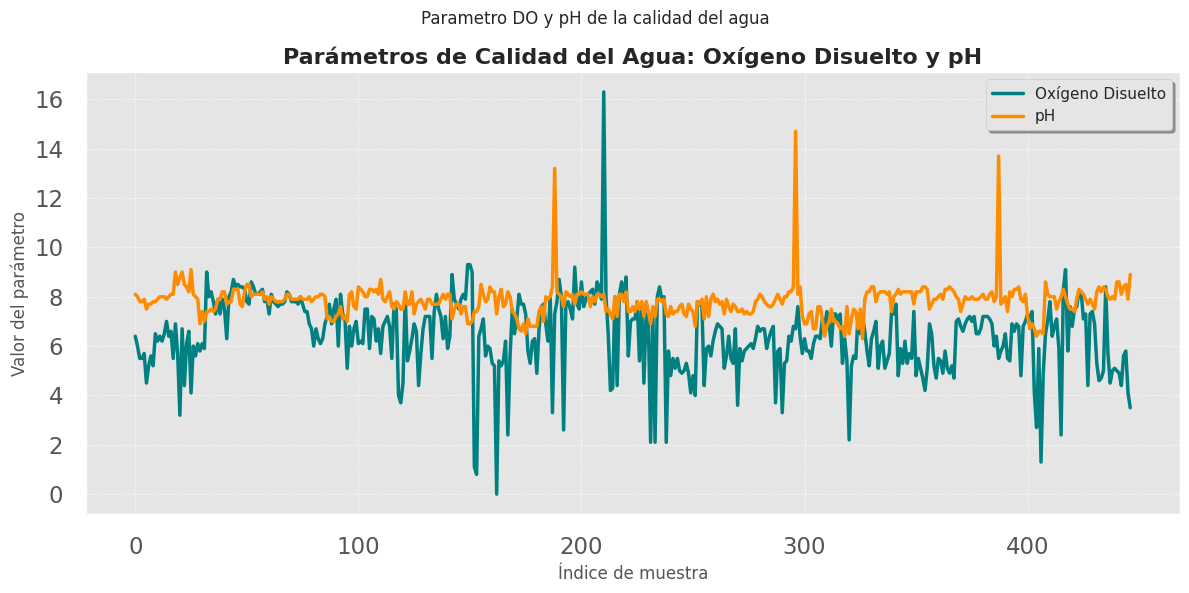

In [160]:
plt.style.use('ggplot')
TAM = len(do_parametro)
FIG, AX1 = plt.subplots(num=None, figsize=(12,6))
AX1.plot(range(0,TAM),
         do_parametro,
         label = "Oxígeno Disuelto",
         color='teal',
         linewidth=2.5,
         markersize=4)
AX1.plot(
    range(TAM), ph_parametro,
    label="pH",
    color='darkorange',
    linewidth=2.5,
    markersize=4
)
AX1.set_title("Parámetros de Calidad del Agua: Oxígeno Disuelto y pH", fontsize=16, fontweight='bold')
AX1.set_xlabel("Índice de muestra", fontsize=12)
AX1.set_ylabel("Valor del parámetro", fontsize=12)
FIG.suptitle('Parametro DO y pH de la calidad del agua')

AX1.legend(fontsize=11, loc='upper right', frameon=True, shadow=True)

AX1.grid(True, linestyle=':', linewidth=0.8)
plt.tight_layout()

plt.show()

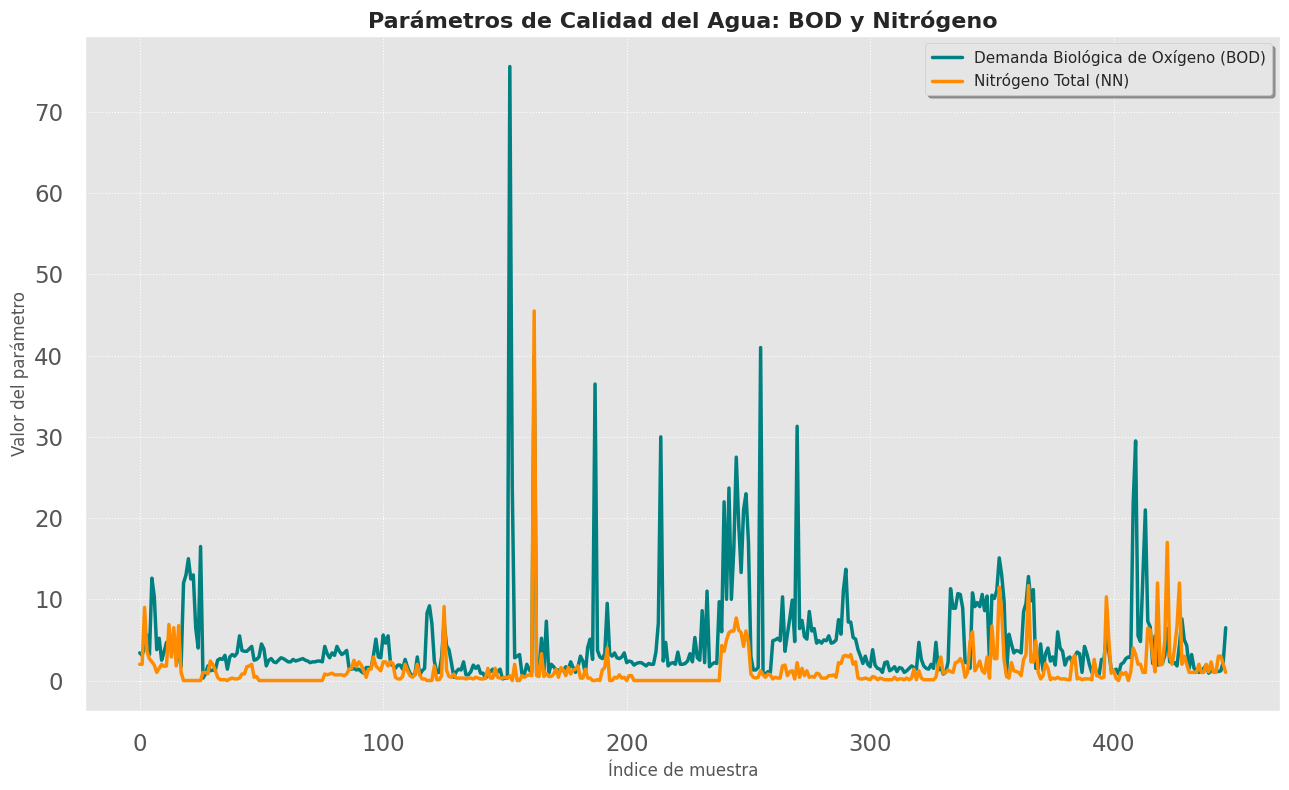

In [161]:
##;se grafica los parametros BOD Y nitrogenos

plt.style.use('ggplot')

TAM = len(BOD_parametro)
FIG, AX1 = plt.subplots(figsize=(13, 8), facecolor='w', edgecolor='k')

AX1.plot(range(TAM), BOD_parametro, label="Demanda Biológica de Oxígeno (BOD)", color='teal', linewidth=2.5, markersize=5)
AX1.plot(range(TAM), NN_parametro, label="Nitrógeno Total (NN)", color='darkorange', linewidth=2.5, markersize=5)

AX1.set_title("Parámetros de Calidad del Agua: BOD y Nitrógeno", fontsize=16, fontweight='bold')
AX1.set_xlabel("Índice de muestra", fontsize=12)
AX1.set_ylabel("Valor del parámetro", fontsize=12)

AX1.legend(fontsize=11, loc='upper right', frameon=True, shadow=True)
AX1.grid(True, linestyle=':', linewidth=0.8)

plt.tight_layout()
plt.show()

* Visualización de concentraciones promedio de **pH** con **Oxigeno Disuelto**

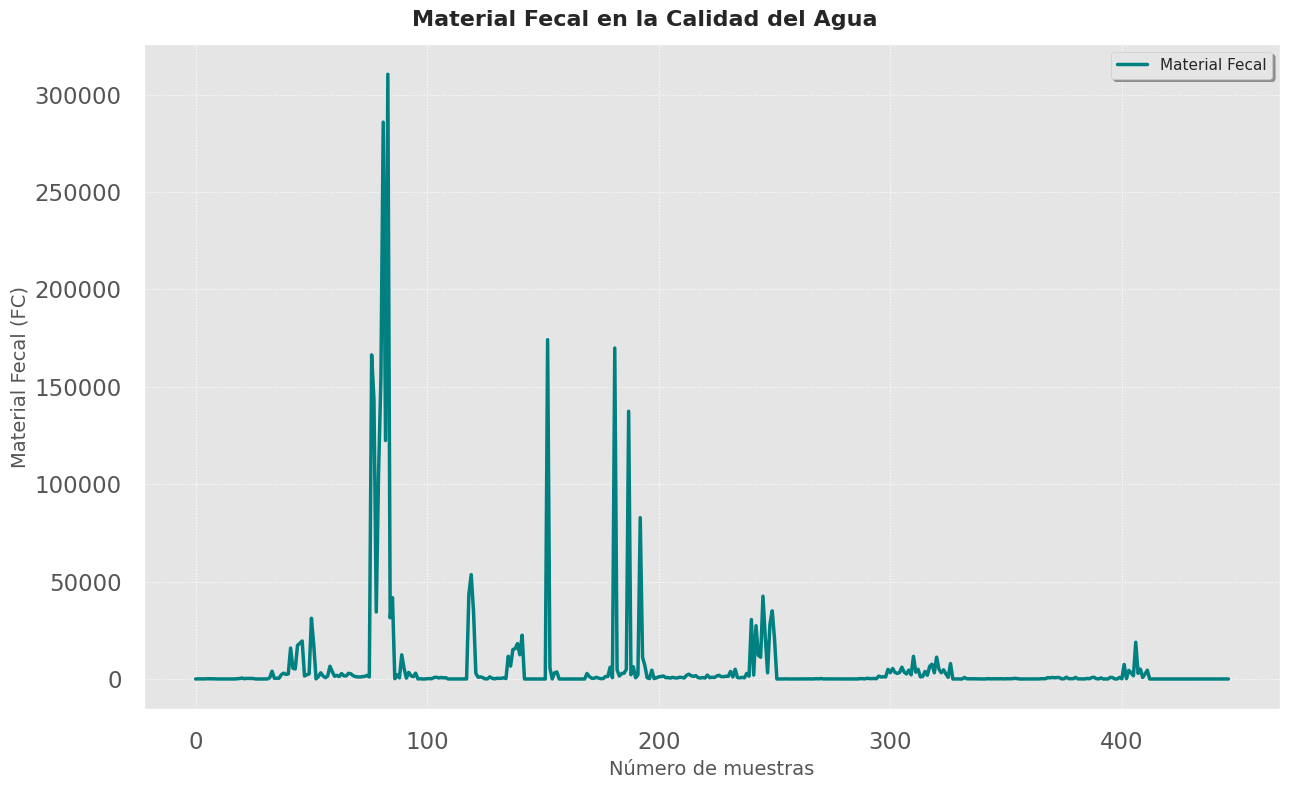

In [162]:
##se grafican la conductividad y el material fecal
TAM = len(FC_parametro)
FIG, AX1 = plt.subplots(figsize=(13, 8), facecolor='w', edgecolor='k')

AX1.plot(range(TAM), FC_parametro, label="Material Fecal", color='teal', linewidth=2.5, linestyle='-', markersize=5)

AX1.set_xlabel("Número de muestras", fontsize=14)
AX1.set_ylabel("Material Fecal (FC)", fontsize=14)

AX1.legend(fontsize=11, loc='upper right', frameon=True, shadow=True)
AX1.grid(True, linestyle=':', linewidth=0.8)

FIG.suptitle("Material Fecal en la Calidad del Agua", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()


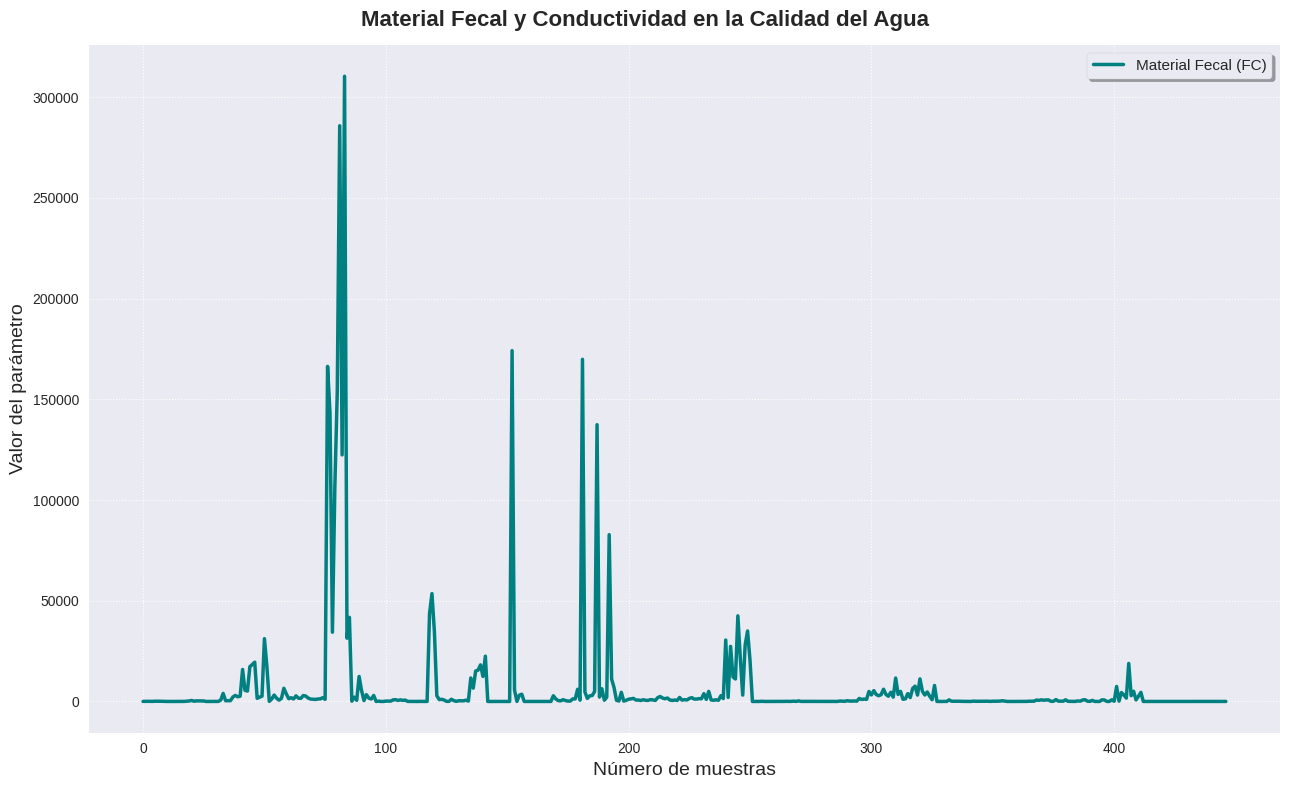

In [163]:
# Create the plot
plt.style.use('seaborn-v0_8')
TAM = len(FC_parametro)
FIG, AX1 = plt.subplots(figsize=(13, 8), facecolor='w', edgecolor='k')

AX1.plot(range(TAM), FC_parametro, label="Material Fecal (FC)", color='teal', linewidth=2.5,  markersize=5)

AX1.set_xlabel("Número de muestras", fontsize=14)
AX1.set_ylabel("Valor del parámetro", fontsize=14)

AX1.legend(fontsize=11, loc='upper right', frameon=True, shadow=True)
AX1.grid(True, linestyle=':', linewidth=0.8)

FIG.suptitle("Material Fecal y Conductividad en la Calidad del Agua", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()


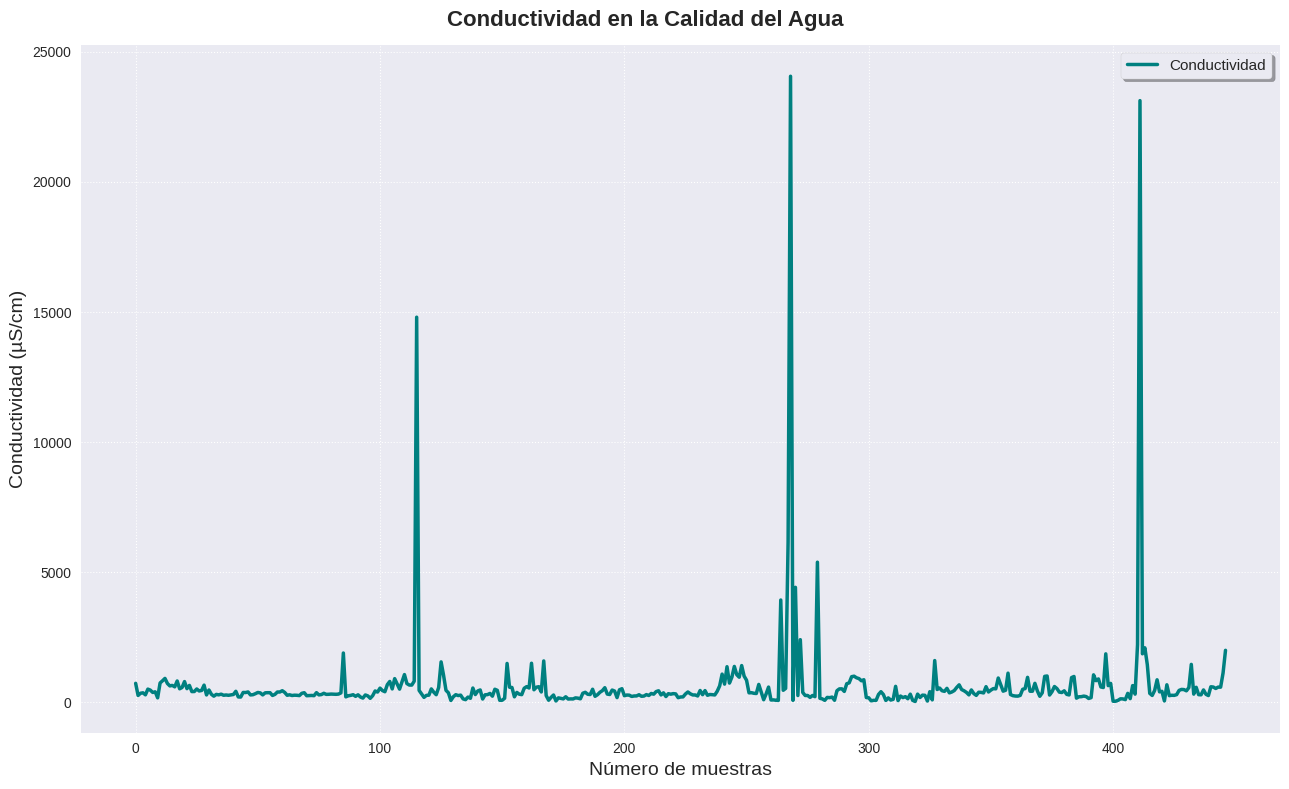

In [164]:
plt.style.use('seaborn-v0_8')

TAM = len(COND_parametro)
FIG, AX1 = plt.subplots(figsize=(13, 8), facecolor='w', edgecolor='k')

AX1.plot(
    range(TAM), COND_parametro,
    label="Conductividad",
    color='teal',
    linewidth=2.5,
    markersize=5
)

AX1.set_xlabel("Número de muestras", fontsize=14)
AX1.set_ylabel("Conductividad (µS/cm)", fontsize=14)

AX1.legend(fontsize=11, loc='upper right', frameon=True, shadow=True)
AX1.grid(True, linestyle=':', linewidth=0.8)

FIG.suptitle("Conductividad en la Calidad del Agua", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

# **Ingeniería de Características**


**Water Quality Index:** El Índice de la Calidad del Agua se calcula agregando  linealmente el índice de calidad por la masa.

WQI = sum(**qr**n * **W**n)

**qr**n: Rango de Calidad para el n parámetro de calidad de agua.

**W**n: Unidad de peso para el n parámetro.

A continuación se calcula un método estándar **[2]** para calcular el rango de calidad **qr** para cada parámetro.

* Rango de calidad para **pH**. Se crea una nueva columna con los rangos **pH** de la calidad del agua **[2]**. A saber:

    + 100: *agua dulce* **pH = [7.0 ; 8.5]**
    + 80:  *agua moderada*     **pH = [6.8 ; 6.9] o [8.5 ; 8.6]**
    + 60:  *agua dura* **pH = [6.7 ; 6.8] o [8.6 ; 8.8]**
    + 40:  *agua muy dura* **pH = [6.5 ; 6.7] o [8.8 ; 9.0]**
    + 0:   rango agua residuales

In [165]:
#crear una nueva columan para los rangos
df02 = df01.withColumn(
    "qrpH",
    F.when((df01.pH >= 7) & (df01.pH <= 8.5), 100)
     .when(((df01.pH > 6.8) & (df01.pH < 6.9)) | ((df01.pH >= 8.5) & (df01.pH < 8.6)), 80)
     .when(((df01.pH > 6.7) & (df01.pH < 6.8)) | ((df01.pH >= 8.8) & (df01.pH < 8.8)), 80)
     .when(((df01.pH > 6.5) & (df01.pH < 6.7)) | ((df01.pH >= 8.8) & (df01.pH < 9)), 80)
     .otherwise(60)
)

* Rango de calidad para **Oxigeno Disuelto**. Se crea una nueva columna con los rangos DO de la calidad del agua **[2]**. A saber:

    + 100: *agua dulce* **DO>=6.0**
    + 80:  *agua moderada* **DO = [5.1, 6.0]**
    + 60:  *agua dura* **DO = [4.1, 5.0]**
    + 40:  *agua muy dura* **DO = [3.0, 4.0]**
    + 0:   rango agua residuales

In [166]:
#crear una nueva columan para los rangos
df02 = df02.withColumn(
    "qrDO",
    F.when(df01.DO >= 6.0, 100)
     .when((df01.DO >= 5.1) & (df01.DO < 6.0), 80)
     .when((df01.DO >= 4.1) & (df01.DO <= 5.0), 60)
     .when((df01.DO >= 3.0) & (df01.DO <= 4.0), 40)
     .otherwise(0)
)

* Rango de calidad para **Conductividad**. Se crea una nueva columna con los rangos CONDUCTIVITY de la calidad del agua **[2]**. A saber:

    + 100: *agua dulce* **CONDUCTIVITY = [0.0,75.0]**
    + 80:  *agua moderada* **CONDUCTIVITY = [75.0, 150.0]**
    + 60:  *agua dura* **CONDUCTIVITY = [150.0, 225.0]**
    + 40:  *agua muy dura* **CONDUCTIVITY = [225.0, 300.0]**
    + 0:   rango agua residuales

In [167]:
df02 = df02.withColumn(
    "qrCOND",
    F.when((df01.CONDUCTIVITY >= 0.0) & (df01.CONDUCTIVITY <= 75.0), 100)
     .when((df01.CONDUCTIVITY > 75.0) & (df01.CONDUCTIVITY <= 150.0), 80)
     .when((df01.CONDUCTIVITY > 150.0) & (df01.CONDUCTIVITY <= 225.0), 60)
     .when((df01.CONDUCTIVITY > 225.0) & (df01.CONDUCTIVITY <= 300.0), 40)
     .otherwise(0)
)


* Rango de calidad para **Demanda Bioquímica de Oxigeno**. Se crea una nueva columna con los rangos **BOD** de la calidad del agua **[2]**. A saber:

    + 100: *agua dulce* **BOD = [0.0,3.0]**
    + 80:  *agua moderada* **BOD = [3.0, 6.0]**
    + 60:  *agua dura* **BOD = [6.0, 80.0]**
    + 40:  *agua muy dura* **BOD = [80.0, 125.0]**
    + 0:   rango agua residuales

In [168]:
df02 = df02.withColumn(
    "qrBOD",
    F.when((df01.BOD >= 0.0) & (df01.BOD <= 3.0), 100)
     .when((df01.BOD > 3.0) & (df01.BOD <= 6.0), 80)
     .when((df01.BOD > 6.0) & (df01.BOD <= 80.0), 60)
     .when((df01.BOD > 80.0) & (df01.BOD <= 125.0), 40)
     .otherwise(0)
)

* Rango de calidad para **Nitratos**. Se crea una nueva columna con los rangos **NITRATE_N_NITRITE_N** de la calidad del agua **[2]**. A saber:

    + 100: *agua dulce* **NITRATE_N_NITRITE_N = [0.0,20.0]**
    + 80:  *agua moderada* **NITRATE_N_NITRITE_N =  [20.0, 50.0]**
    + 60:  *agua dura* **NITRATE_N_NITRITE_N = [50.0, 100.0]**
    + 40:  *agua muy dura* **NITRATE_N_NITRITE_N = [100.0, 200.0]**
    + 0:   rango agua residuales

In [169]:
df02 = df02.withColumn(
    "qrNITR",
    F.when((df01.NITRATE_N_NITRITE_N >= 0.0) & (df01.NITRATE_N_NITRITE_N <= 20.0), 100)
     .when((df01.NITRATE_N_NITRITE_N > 20.0) & (df01.NITRATE_N_NITRITE_N <= 50.0), 80)
     .when((df01.NITRATE_N_NITRITE_N > 50.0) & (df01.NITRATE_N_NITRITE_N <= 100.0), 60)
     .when((df01.NITRATE_N_NITRITE_N > 100.0) & (df01.NITRATE_N_NITRITE_N <= 200.0), 40)
     .otherwise(0))

* Rango de calidad para **Coliforme Fecal**. Se crea una nueva columna con los rangos FECAL_COLIFORM de la calidad del agua **[2]**. A saber:

    + 100: *agua dulce* **FECAL_COLIFORM = [0.0,5.0]**
    + 80:  *agua moderada* **FECAL_COLIFORM = [5.0, 50.0]**
    + 60:  *agua dura* **FECAL_COLIFORM = [50.0, 500.0]**
    + 40:  *agua muy dura* **FECAL_COLIFORM = [500.0, 10000.0]**
    + 0:   rango agua residuales

In [170]:
df02 = df02.withColumn(
    "qrFEC",
    F.when((df01.FECAL_COLIFORM >= 0.0) & (df01.FECAL_COLIFORM < 5.0), 100)
     .when((df01.FECAL_COLIFORM >= 5.0) & (df01.FECAL_COLIFORM < 50.0), 80)
     .when((df01.FECAL_COLIFORM >= 50.0) & (df01.FECAL_COLIFORM < 500.0), 60)
     .when((df01.FECAL_COLIFORM >= 500.0) & (df01.FECAL_COLIFORM < 10000.0), 40)
     .otherwise(0))

A continuación se cálcula el WQI para cada parámetro.

El peso del agua puede ser calculado por el producto de su volumen por su densidad. La densidad del agua es aproximadamente 1 gramo por centimetro cúbico (g/cm^3)

In [171]:
# inspeccion visual

df02.show(10)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+------+-----+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrpH|qrDO|qrCOND|qrBOD|qrNITR|qrFEC|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+------+-----+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0| 100| 100|     0|   80|   100|  100|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0| 100| 100|    40|   80|   100|   60|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|       355.0| 4.2|                9.0|          59.0| 100|  80|     0|   80|   100|   60|
|        2179|GODAVARI RIVER AT...|MAHARASHTRA|24.8|5.5|7.8|       371.0| 5.6|               3.55|  

Finalmente se calcula el **Índice de Calidad del Agua**

* A continuación se clasifica el agua sobre la base de su índice de calidad **[2]**

* Clasificación de calidad del agua:

    + Excelente: *agua dulce* **WQI = [0.0,25.0]**
    + Buena:  *agua moderada* **WQI = [26.0, 50.0]**
    + Baja:  *agua dura* **WQI = [51.0, 75.0]**
    + Muy_Baja:  *agua muy dura* **WQI = [76.0, 100.0]**
    + Inadecuada:   rango agua residuales

Se calcula el WQI para cada parámetro. La masa del agua puede ser calculada por el producto de su volumen por su densidad. La densidad del agua es aproximadamente 1 gramo por centímetro cúbico (g/cm^3)

In [172]:
df02.columns


['STATION CODE',
 'LOCATIONS',
 'STATE',
 'TEMP',
 'DO',
 'pH',
 'CONDUCTIVITY',
 'BOD',
 'NITRATE_N_NITRITE_N',
 'FECAL_COLIFORM',
 'qrpH',
 'qrDO',
 'qrCOND',
 'qrBOD',
 'qrNITR',
 'qrFEC']

In [173]:
from pyspark.sql.functions import round
df03 = (
    df02.withColumn("wpH", round(df02.qrpH * 0.165, 2))
        .withColumn("wDO", round(df02.qrDO * 0.234, 2))
        .withColumn("wCOND", round(df02.qrCOND * 0.234, 2))
        .withColumn("wBOD", round(df02.qrBOD * 0.009, 2))
        .withColumn("wNITR", round(df02.qrNITR * 0.028, 2))
        .withColumn("wFEC", round(df02.qrFEC * 0.281, 2))
)

In [174]:
df03.show(10)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+------+-----+----+-----+-----+----+-----+-----+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrpH|qrDO|qrCOND|qrBOD|qrNITR|qrFEC| wpH|  wDO|wCOND|wBOD|wNITR| wFEC|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+------+-----+----+-----+-----+----+-----+-----+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0| 100| 100|     0|   80|   100|  100|16.5| 23.4|  0.0|0.72|  2.8| 28.1|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0| 100| 100|    40|   80|   100|   60|16.5| 23.4| 9.36|0.72|  2.8|16.86|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|       355.0| 4.2|  

In [175]:
#se crea la columan WGI
df04 = df03.withColumn("WQI",round(df03.wpH + df03.wDO + df03.wCOND + df03.wBOD + df03.wNITR + df03.wFEC,2))
df04.show(10)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+------+-----+----+-----+-----+----+-----+-----+-----+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrpH|qrDO|qrCOND|qrBOD|qrNITR|qrFEC| wpH|  wDO|wCOND|wBOD|wNITR| wFEC|  WQI|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+------+-----+----+-----+-----+----+-----+-----+-----+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0| 100| 100|     0|   80|   100|  100|16.5| 23.4|  0.0|0.72|  2.8| 28.1|71.52|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0| 100| 100|    40|   80|   100|   60|16.5| 23.4| 9.36|0.72|  2.8|16.86|69.64|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.

* A continuación se clasifica el agua sobre la base de su índice de calidad **[2]**

* Clasificación de calidad del agua:

    + Excelente: *agua dulce* **WQI = [0.0,25.0]**
    + Buena:  *agua moderada* **WQI = [26.0, 50.0]**
    + Baja:  *agua dura* **WQI = [51.0, 75.0]**
    + Muy_Baja:  *agua muy dura* **WQI = [76.0, 100.0]**
    + Inadecuada:   rango agua residuales

In [176]:
df05 = df04.withColumn(
    "CALIDAD",
    F.when((df04.WQI >= 0.0) & (df04.WQI <= 25.0), 'Excelente')
     .when((df04.WQI > 25.0) & (df04.WQI <= 50.0), 'Buena')
     .when((df04.WQI > 50.0) & (df04.WQI <= 75.0), 'Baja')
     .when((df04.WQI > 75.0) & (df04.WQI <= 100.0), 'Muy_Baja')
     .otherwise('Inadecuada')
)

In [177]:
df05.show(10)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+------+-----+----+-----+-----+----+-----+-----+-----+--------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrpH|qrDO|qrCOND|qrBOD|qrNITR|qrFEC| wpH|  wDO|wCOND|wBOD|wNITR| wFEC|  WQI| CALIDAD|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+------+-----+----+-----+-----+----+-----+-----+-----+--------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0| 100| 100|     0|   80|   100|  100|16.5| 23.4|  0.0|0.72|  2.8| 28.1|71.52|    Baja|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0| 100| 100|    40|   80|   100|   60|16.5| 23.4| 9.36|0.72|  2.8|16.86|69.64|    Baja|
|    

In [178]:
type(df01)

pyspark.sql.dataframe.DataFrame

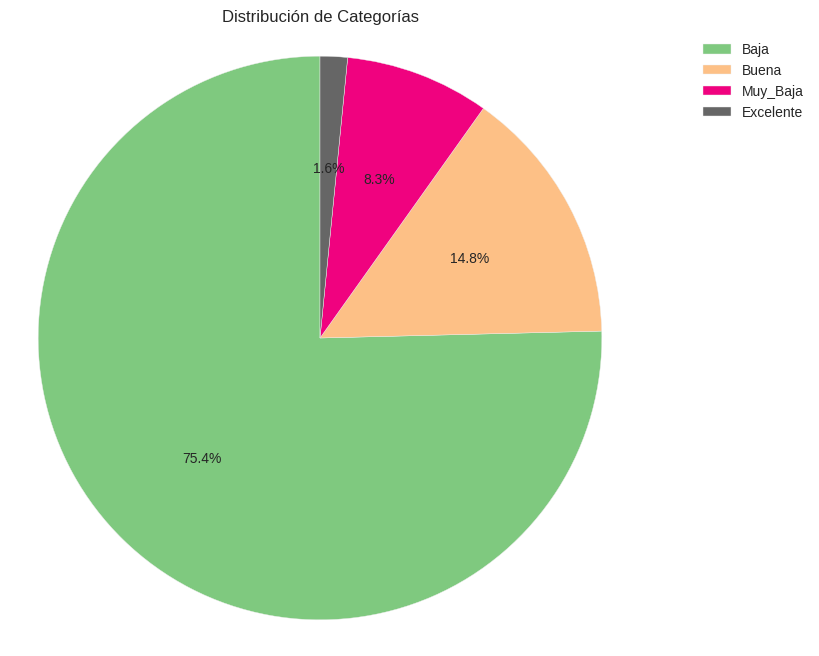

In [179]:
# Se visualiza la proporción de la calidad de agua con un Pie chart.
df_temp = df05.toPandas()
proporcion_calidad_agua = df_temp['CALIDAD'].value_counts()

cmap = plt.get_cmap('Accent')
colores = cmap(np.linspace(0, 1, len(proporcion_calidad_agua)))

plt.figure(figsize=(8, 8))
plt.pie(
    proporcion_calidad_agua,
    autopct='%1.1f%%',
    startangle=90,
    colors=colores
)
plt.legend(
    labels=proporcion_calidad_agua.index,
    loc='upper right',
    bbox_to_anchor=(1.3, 1)
)
plt.title('Distribución de Categorías')
plt.axis('equal')
plt.show()


# recordad que son muy poco los parametros para un estudio real de la calidad del agua.

#**Visualización de los datos por Estados de la INDIA**

* Se visualizan los datos obtenidos de CALIDAD en cada región/estado de la INDIA

In [180]:
#Primero se obtienen los nombres de regiones sobre el Dataframe de Calidad
df05.select('STATE').distinct().collect()


[Row(STATE='WEST BENGAL'),
 Row(STATE='GOA'),
 Row(STATE='RAJASTHAN'),
 Row(STATE='HIMACHAL PRADESH'),
 Row(STATE='GUJARAT'),
 Row(STATE='BIHAR'),
 Row(STATE='KARNATAKA'),
 Row(STATE='UTTAR PRADESH'),
 Row(STATE='MADHYA PRADESH'),
 Row(STATE='MAHARASHTRA'),
 Row(STATE='PUNJAB'),
 Row(STATE='TAMILNADU'),
 Row(STATE='ANDHRA PRADESH'),
 Row(STATE='KERALA'),
 Row(STATE='ASSAM')]

* Se observan los nombres en el GPD, para hacer que sean similares frente a los del dataframe

In [181]:
#Se visualiza los tipos de datos del dataFrame geografico de pandas
gpdf00.dtypes


,0
st_nm,object
geometry,geometry


In [182]:
gpdf00.columns

Index(['st_nm', 'geometry'], dtype='object')

In [183]:
#Nombres de los estados en GeoPandas
gpdf00['st_nm'].unique()


array(['Andaman & Nicobar Island', 'Arunanchal Pradesh', 'Assam', 'Bihar',
       'Chandigarh', 'Chhattisgarh', 'Dadara & Nagar Havelli',
       'Daman & Diu', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Jammu & Kashmir', 'Jharkhand', 'Karnataka', 'Kerala',
       'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur',
       'Meghalaya', 'Mizoram', 'Nagaland', 'NCT of Delhi', 'Puducherry',
       'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana',
       'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal', 'Odisha',
       'Andhra Pradesh'], dtype=object)

In [184]:
#Se ajustan los nombres de GPD, eliminando caracteres y extensiones de nombres
gpdf01 = gpdf00.replace({
    'Andaman & Nicobar Island' : 'Andaman and Nicobar Islands',
    'Dadara & Nagar Havelli' : 'Dadara and Nagar Havelli',
    'Daman & Diu' : 'Daman and Diu',
    'Jammu & Kashmir' : 'Jammu and Kashmir',
    'NCT of Delhi' : 'Delhi'
})
gpdf01['st_nm'].unique()


array(['Andaman and Nicobar Islands', 'Arunanchal Pradesh', 'Assam',
       'Bihar', 'Chandigarh', 'Chhattisgarh', 'Dadara and Nagar Havelli',
       'Daman and Diu', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Jammu and Kashmir', 'Jharkhand', 'Karnataka', 'Kerala',
       'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur',
       'Meghalaya', 'Mizoram', 'Nagaland', 'Delhi', 'Puducherry',
       'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana',
       'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal', 'Odisha',
       'Andhra Pradesh'], dtype=object)

Se hacen cambios sobre el dataframe spark para coincidir nombres

* Para efectos de pintar el mapa se pasa el spark dataframe a pandas
* El nombre de TAMILNADU se cambia por TAMIL NADU
* Se deja sólo la letra inicial mayúsula sobre Dataframe

In [185]:
#Se cambia a objeto pandas
pandasDF = df05.toPandas()

#Cambio TAMILNADU a TAMIL NADU
pandasDF['STATE'].replace({'TAMILNADU': 'TAMIL NADU'}, inplace =True)


#Se deja letra inicial mayúscula en columna 'STATE'
pandasDF['STATE'] =  pandasDF['STATE'].str.title()

#Se comprueba el cambio
pandasDF['STATE'].head()

,STATE
0,Maharashtra
1,Maharashtra
2,Maharashtra
3,Maharashtra
4,Maharashtra


In [186]:
#Se cambia el nombre en el gpd a STATES
gpdf02 = gpdf01.rename(columns={'st_nm': 'STATE'})
#Se combinan los  dataframes (gpdf02, pandasdf) outer: union de claves 'STATE' de ambos dataframes
dfMap = pd.merge(gpdf02, pandasDF, on='STATE', how='outer')

In [187]:

#Se toman puntos a bajo coste que garantizan estar dentro de la geometria (mapa): columna nueva 'coordenadas'
dfMap['coordenadas'] = dfMap['geometry'].apply(
    lambda x: tuple( __builtins__.round(coord, 2) for coord in x.representative_point().coords[0])
)
dfMap =dfMap.drop_duplicates(subset=['STATE'])
dfMap.head(10)

,STATE,geometry,STATION CODE,LOCATIONS,TEMP,DO,pH,CONDUCTIVITY,BOD,NITRATE_N_NITRITE_N,...,qrFEC,wpH,wDO,wCOND,wBOD,wNITR,wFEC,WQI,CALIDAD,coordenadas
0,Andaman and Nicobar Islands,"MULTIPOLYGON (((93.71976 7.20707, 93.71909 7.2...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(92.83, 12.61)"
1,Andhra Pradesh,"MULTIPOLYGON (((81.1038 17.82269, 81.1061 17.8...",2360.0,"GODAVARI AT BASARA, ADILABAD",28.000000,5.5,8.1,826.0,1.7,1.0,...,80.0,16.5,18.72,0.00,0.9,2.8,22.48,61.40,Baja,"(79.62, 15.89)"
35,Arunanchal Pradesh,"POLYGON ((96.16261 29.38078, 96.1686 29.37432,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(95.03, 28.06)"
36,Assam,"MULTIPOLYGON (((89.74323 26.30362, 89.7429 26....",1260.0,BRAHAMPUTRA AT KHERGHAT (AFTER CONFL. WITH DIB...,22.299999,7.2,7.1,216.0,1.5,1.4,...,60.0,16.5,23.40,14.04,0.9,2.8,16.86,74.50,Baja,"(90.76, 26.05)"
58,Bihar,"MULTIPOLYGON (((84.5072 24.26323, 84.50355 24....",1074.0,"GANGA AT BUXAR,BIHAR",24.500000,8.4,8.1,371.0,2.5,0.0,...,40.0,16.5,23.40,0.00,0.9,2.8,11.24,54.84,Baja,"(86.13, 25.9)"
118,Chandigarh,"POLYGON ((76.84147 30.75996, 76.83599 30.73623...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(76.78, 30.73)"
119,Chhattisgarh,"POLYGON ((83.33532 24.09885, 83.35346 24.09627...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(81.51, 20.95)"
120,Dadara and Nagar Havelli,"POLYGON ((73.20657 20.12216, 73.20797 20.1065,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(73.01, 20.21)"
121,Daman and Diu,"MULTIPOLYGON (((72.89335 20.44539, 72.89281 20...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(70.93, 20.72)"
122,Delhi,"POLYGON ((77.09361 28.8694, 77.10973 28.86722,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(77.13, 28.64)"


In [188]:
## se instala mapClassfy
!pip install mapclassify

* Se procede a pintar con SEABORN

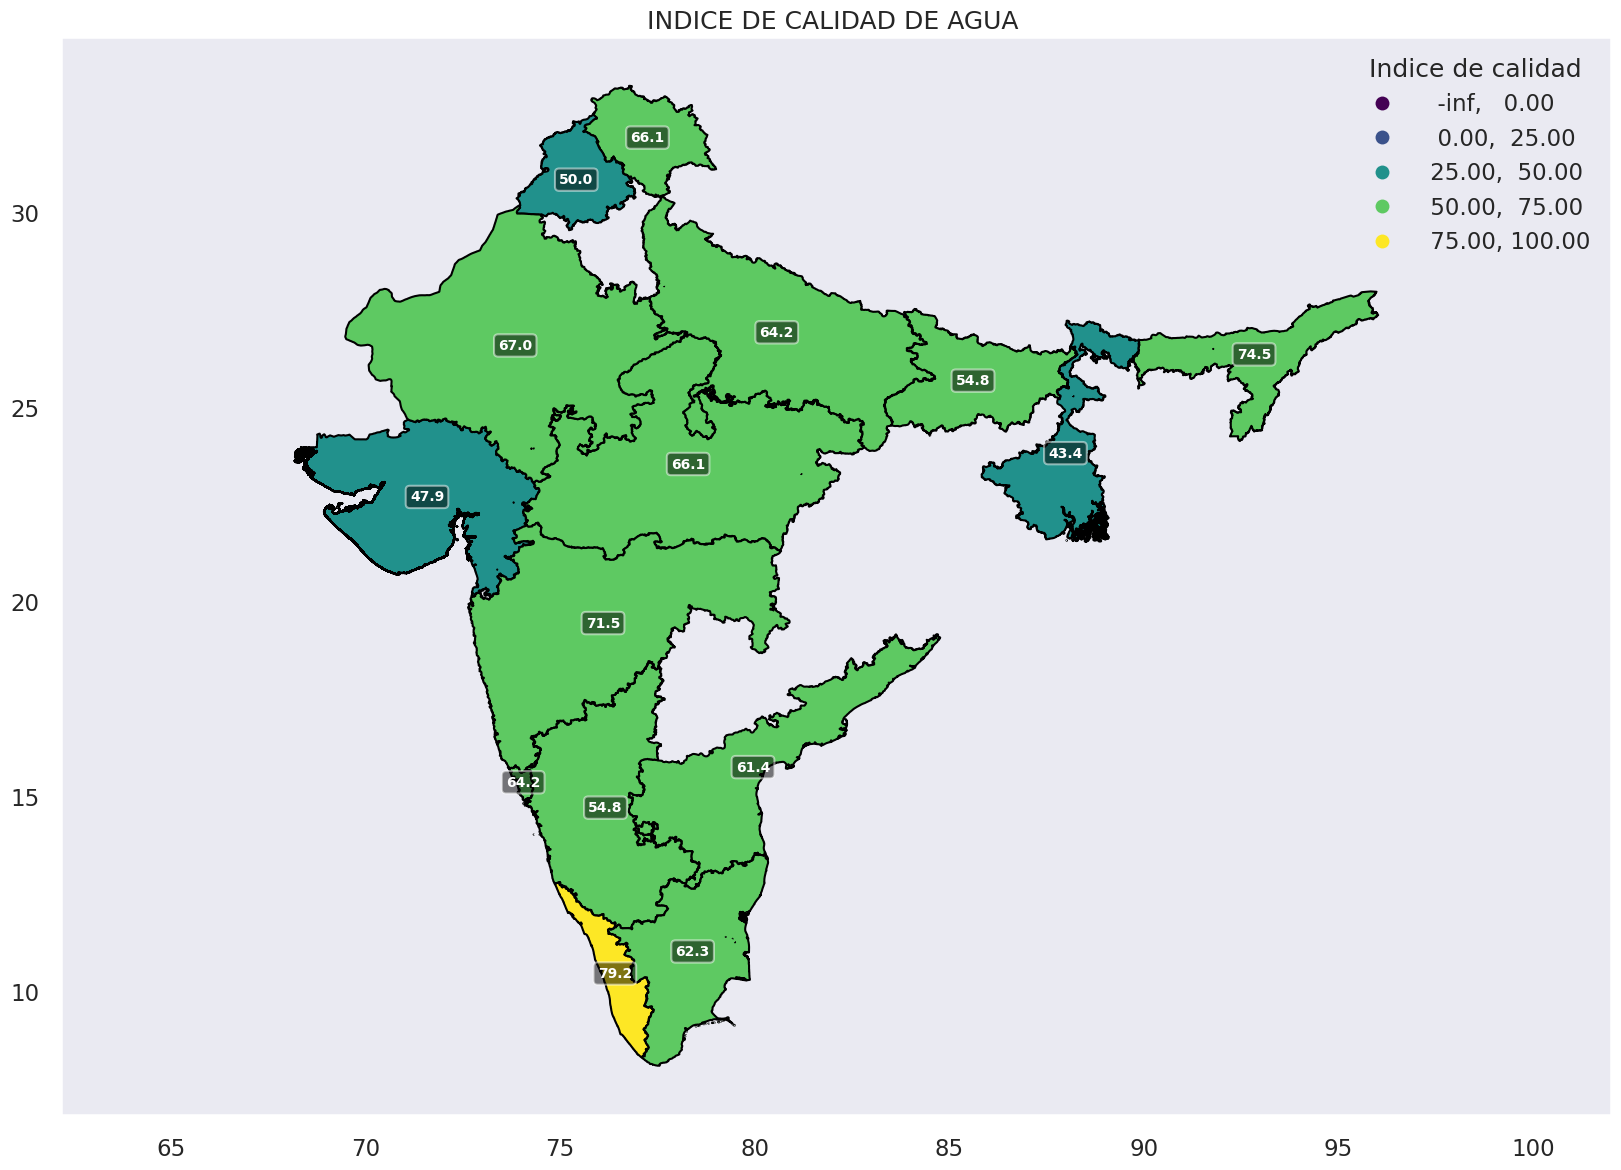

In [189]:
sns.set_context("talk")
sns.set_style("dark")
cMap = 'viridis'
sizeFig = (20,14)
ax = dfMap.plot(column="WQI", cmap = cMap, figsize=sizeFig, classification_kwds = dict(bins = [0,25,50,75,100]), edgecolor = 'black', legend=True, scheme = 'User_Defined')
#bucle para la leyenda de WQI
for idx, row in dfMap.iterrows():
    if pd.notna(row['WQI']):
      centroid = row.geometry.centroid
      ax.text(centroid.x, centroid.y, f"{row['WQI']:.1f}",
        fontsize=10, fontweight='bold', color='white',
        ha='center', va='center', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.3'))



ax.get_legend().set_title('Indice de calidad')
ax.set_title('INDICE DE CALIDAD DE AGUA ')
plt.axis('equal')
plt.show()

In [190]:
!pip install mapclassify

* Se requiere hacer una gráfica de WQI para cada STATE

In [191]:
##Se convierte el DFpandas a Dataframe spark

sparkDF00 = spark.createDataFrame(pandasDF)

#### Se crea una Tabla de Vista Temporal para hacer consultas SQL
sparkDF00.createOrReplaceTempView("df10_sql")

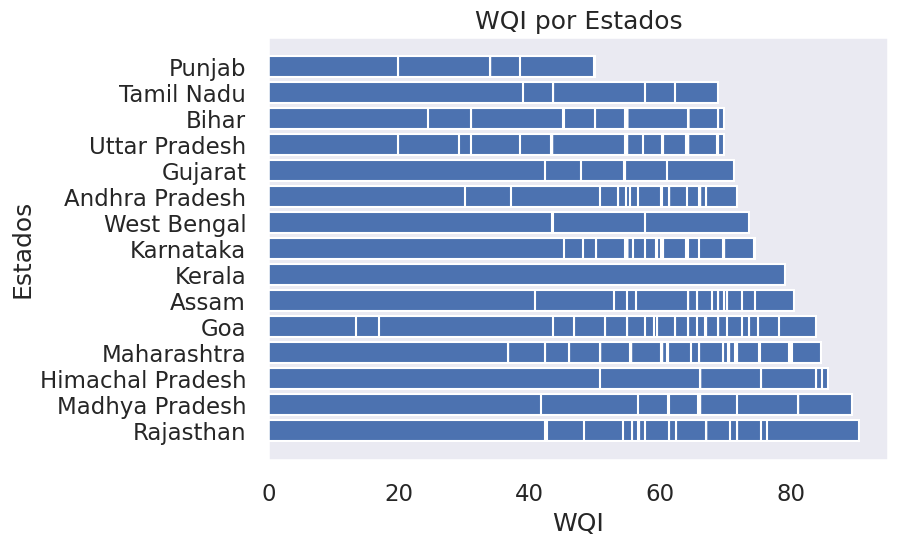

In [192]:
sns.set_context("talk")
sns.set_style("dark")

#Se selecciona los nombres de los estados
estados = spark.sql("SELECT  STATE FROM df10_sql")
estados = estados.rdd.map(lambda fila: fila.STATE).collect()



#Se selecciona los valores de WQI
val_WQI = spark.sql("SELECT  WQI FROM df10_sql")
val_WQI = val_WQI.rdd.map(lambda fila: fila.WQI).collect()

#Se grafica el histograma
#plt.barh(estados, val_WQI)
sorted_data = sorted(zip(val_WQI, estados), reverse=True)
sorted_wqi, sorted_estados = zip(*sorted_data)

plt.barh(sorted_estados, sorted_wqi)

plt.xlabel('WQI')
plt.ylabel('Estados')
plt.title('WQI por Estados')

plt.show()



#**Creación de Modelo: Regresión Lineal**

* Se requiere predecir el valor WQI
* Se crea un vector ensamblador con las columnas **"Rangos de Calidad (qr)"**
* Se normalizan las columnas a través de Normalizer
* Se importa LinearRegression y se aplica los datos con el vector normalizado
* Se hace un "pipeline" para incluir el modelo
* Se separa los datos aleatoriamente (80%:entrenamiento, 20%:prueba)
* Se entrena el modelo con los datos de entrenamiento
* Se obtienen las predicciones con los datos de prueba y se muestran
* Se revisa el rendimiento del modelo con la métrica r2

In [193]:
 sparkDF00.columns

['STATION CODE',
 'LOCATIONS',
 'STATE',
 'TEMP',
 'DO',
 'pH',
 'CONDUCTIVITY',
 'BOD',
 'NITRATE_N_NITRITE_N',
 'FECAL_COLIFORM',
 'qrpH',
 'qrDO',
 'qrCOND',
 'qrBOD',
 'qrNITR',
 'qrFEC',
 'wpH',
 'wDO',
 'wCOND',
 'wBOD',
 'wNITR',
 'wFEC',
 'WQI',
 'CALIDAD']

In [194]:
# importar biblioteca
from pyspark.ml.feature import VectorAssembler, Normalizer
#Se normalizan en un vector
vector_qr = VectorAssembler(inputCols=['qrpH',
 'qrDO',
 'qrCOND',
 'qrBOD',
 'qrNITR',
 'qrFEC'], outputCol="features")
normalizer = Normalizer(inputCol="features", outputCol="feat_normalized")

In [195]:

#Se prepara el modelo de Regresión Lineal
from pyspark.ml.regression import LinearRegression
modelo_a_lineal =  LinearRegression(featuresCol='feat_normalized', labelCol='WQI', maxIter=10, regParam=0.3, elasticNetParam= 0.2)



In [196]:
from pyspark.ml import Pipeline
#Se crea el pipeline
pipe_A = Pipeline(stages=[vector_qr, normalizer, modelo_a_lineal])

In [197]:
#Separación de datos aleatoriamente: 20/80 split prueba/test
train_data, test_data = sparkDF00.randomSplit([0.2, 0.8])


In [198]:
#Se crea el modelo LR para entrenamiento
LR_modelo = pipe_A.fit(train_data)


In [199]:
#Se hacen las predicciones con los datos de entrenamiento
pred_model_A = LR_modelo.transform(train_data)
pred_model_A.select("WQI", "prediction").show(14)

+-----+------------------+
|  WQI|        prediction|
+-----+------------------+
| 64.2| 64.02168059963122|
|54.66|55.266787735746945|
|54.84| 55.44939111526064|
|68.88| 68.65247372619712|
| 43.6| 46.39182614097599|
|79.18| 77.55021906205214|
|71.52| 71.12105863611922|
| 55.6| 55.48639586009272|
| 74.5| 73.12641226857043|
| 64.2| 64.02168059963122|
|43.42| 45.72101930366926|
|43.42| 45.72101930366926|
|66.08| 65.51913377240692|
|68.88| 68.65247372619712|
+-----+------------------+
only showing top 14 rows



In [200]:
#Rendimiento del modelo con r2 como métrica con datos de entrenamiento
metricasR2 = LR_modelo.stages[2].summary.r2

print(f'R2 para datos de prueba: {__builtins__.round(metricasR2 * 100, 2)}')

R2 para datos de prueba: 98.95


In [201]:
#Se hacen las predicciones con los datos de prueba
pred_test_A = LR_modelo.transform(test_data)

In [202]:
pred_test_A.select("WQI", "prediction").show(14)

+-----+-----------------+
|  WQI|       prediction|
+-----+-----------------+
|71.52|71.12105863611922|
| 30.1|22.79706589690592|
| 71.7|70.52934111084531|
|69.64|69.19124174151955|
|69.82|68.71406977368895|
|54.84|55.44939111526064|
| 64.2|64.02168059963122|
| 64.2|64.02168059963122|
|43.42|45.72101930366926|
|43.42|45.72101930366926|
|43.42|45.72101930366926|
|43.42|45.72101930366926|
|43.42|45.72101930366926|
| 64.2|64.02168059963122|
+-----+-----------------+
only showing top 14 rows



In [203]:
# Se evalua el modelo con los datos de prueba
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="WQI", predictionCol="prediction", metricName="r2")
r2_test_direct = evaluator.evaluate(pred_test_A)
print(f"R2 con datos de prueba: {__builtins__.round(r2_test_direct * 100, 2)}%")

R2 con datos de prueba: 97.98%


Se puede concluir que se tiene un buen modelo de regresion lineal. Se Realiza un ScatterPlot para comprobar.

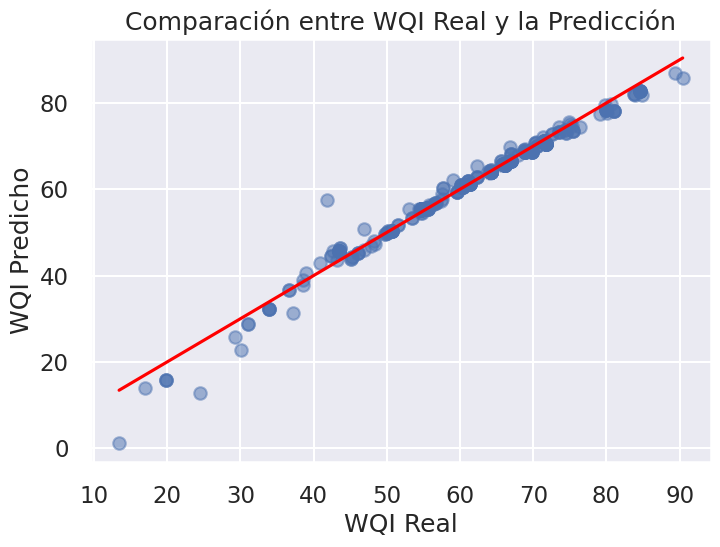

In [204]:
# Revisión visual del modelo (si usas matplotlib)
import matplotlib.pyplot as plt

# Convertimos el DataFrame de Spark a Pandas
df = pred_test_A.select("WQI", "prediction").toPandas()

# Gráfico de dispersión: valores reales vs predichos
plt.scatter(df["WQI"], df["prediction"], alpha=0.5)

# Línea roja ideal: donde predicción == valor real
plt.plot([df["WQI"].min(), df["WQI"].max()],
         [df["WQI"].min(), df["WQI"].max()],
         color="red")

# Etiquetas y título en español
plt.xlabel("WQI Real")
plt.ylabel("WQI Predicho")
plt.title("Comparación entre WQI Real y la Predicción")
plt.grid(True)
plt.show()

#**Creación de Modelo: Aprendizaje Profundo (Deep Learning)**

* Se requiere predecir el valor WQI
* Se crea un DF en pandas, se crea los vectores numpy de columnas **"Rangos de Calidad (qr)"** y **WQI**
* Se importa Scikit-Learn, para separar los datos (20% para prueba)
* Se importa Keras Sequential con layers Dense
* Se inicializa el modelo, y se añaden las capas
* Se compila el modelo con el optimizador Adam y la función de pérdida error cuadrático medio.
* Se realiza el entrenamiento

In [205]:
#Se obtienen en vector numpy datos de los rangos de calidad de los parámetros (qrParametros)
datos = pandasDF[['qrpH', 'qrDO', 'qrCOND', 'qrBOD', 'qrNITR', 'qrFEC']].values
#Se obtienen en vector numpy datos de valor a predecir "WQI"
prede = pandasDF.iloc[:,22:23].values


In [206]:
#Separación de datos con scikit-learn: train_test_split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(datos, prede, test_size=0.2, random_state=42)

In [207]:
# Se revisa que se hayan realizado bien las divisiones de los datos
print(f"Cantidad de datos totales = {pandasDF.shape}")
print(f"Cantidad de datos entrenamietno = {x_train.shape}")
print(f"Cantidad de datos Prueba = {x_test.shape}")
print(f"Cantidad de datos entrenamiento = {y_train.shape}")
print(f"Cantidad de datos Prueba = {y_test.shape}")

Cantidad de datos totales = (447, 24)
Cantidad de datos entrenamietno = (357, 6)
Cantidad de datos Prueba = (90, 6)
Cantidad de datos entrenamiento = (357, 1)
Cantidad de datos Prueba = (90, 1)


In [208]:
#Se importa instancia TensorFlow
import keras
from keras.models import Sequential
from keras.layers import Dense

In [209]:
#Se ajustan las variables
epocas = 200
lotes = 81

#Se inicializa el modelo con las capas
modelo_DL = Sequential()
modelo_DL.add(Dense(350, input_dim=6, activation='relu'))
modelo_DL.add(Dense(350, activation='relu'))
modelo_DL.add(Dense(350, activation='relu'))
modelo_DL.add(Dense(1, activation='linear'))

In [210]:
## Se compila el modelo con el optimizador Adam y la funcoin de perdida error cuadratico meido.
keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999, amsgrad=False)
modelo_DL.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])

In [211]:
#Se presenta el resumen del modeloDL
modelo_DL.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 350)                 │           2,450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 350)                 │         122,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 350)                 │         122,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             351 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 248,501 (970.71 KB)

 Trainable params: 248,501 (970.71 KB)

 Non-trainable params: 0 (0.00 B)

In [212]:
##Se entrena el modelo

rendi_Mod_DL = modelo_DL.fit(x_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1536.7101 - mse: 1536.7101
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 71.4061 - mse: 71.4061
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 20.2808 - mse: 20.2808
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 8.0936 - mse: 8.0936
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 3.4608 - mse: 3.4608
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1450 - mse: 1.1450
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.6463 - mse: 0.6463
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4135 - mse: 0.4135
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4621 - mse: 0.4621
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2294 - mse: 0.2294
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1505 - mse: 0.1505
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1390 - mse: 0.1390
Epoch 13/50
12/12 ━━━━━━━━━

In [213]:
#Se calcula la predicción
historial = modelo_DL.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test), verbose=0,)


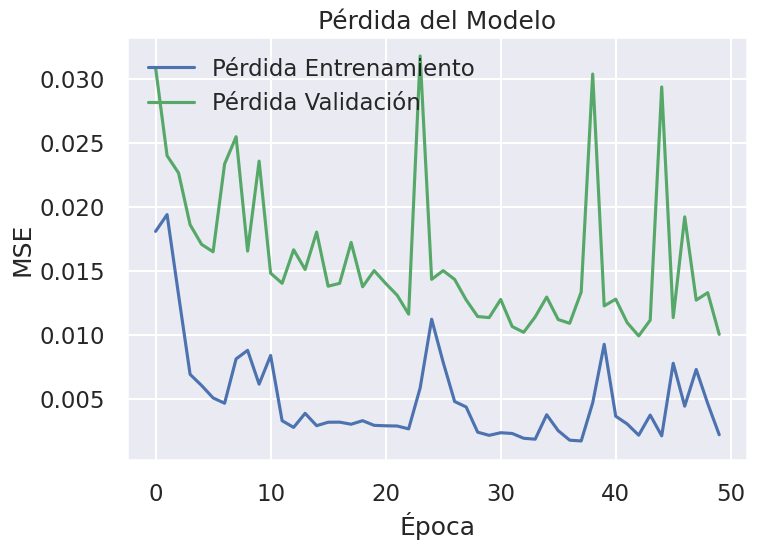

In [214]:
#Se pinta la perdida: rendimiento del modelo
plt.plot(historial.history['loss'], label='Pérdida Entrenamiento')
plt.plot(historial.history['val_loss'], label='Pérdida Validación')
plt.title('Pérdida del Modelo')
plt.ylabel('MSE')
plt.xlabel('Época')
plt.legend()
plt.grid(True)
plt.show()

SE ve que el modelo aprende y mejora su rendimiento a medida que que pasa cada iteración

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


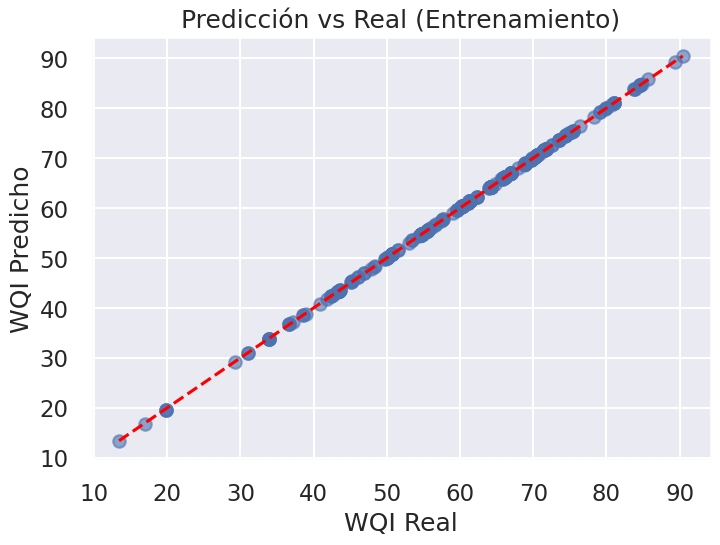

In [215]:
#Se pinta las predicciones sobre datos conocidos (entrenamiento)
y_pred_train = modelo_DL.predict(x_train)
plt.scatter(y_train, y_pred_train, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.title("Predicción vs Real (Entrenamiento)")
plt.xlabel("WQI Real")
plt.ylabel("WQI Predicho")
plt.grid(True)
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


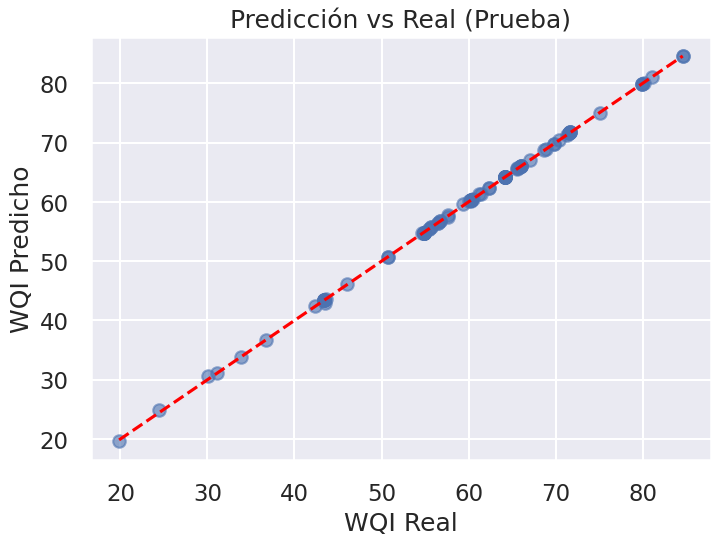

In [216]:
#Se pinta las predicciones sobre datos desconocidos (prueba)
y_pred_test = modelo_DL.predict(x_test)
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Predicción vs Real (Prueba)")
plt.xlabel("WQI Real")
plt.ylabel("WQI Predicho")
plt.grid(True)
plt.show()

#**Predicción de la Calidad del Agua**

* Hasta ahora se predice el Indice de Calida de Agua.
* Se requiere clasificar el agua según el WQI que se predice y así predecir su calidad.
* Se crea un modelo de Regresión Logística para predecir valores por categorias.
* La columna 'CALIDAD' contiene formato 'string', se convierte a 'StringIndexer'
* Se crea un vector assembler para los datos del índice
* Se normaliza los valores en el vector

In [217]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, IndexToString, VectorAssembler, MinMaxScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [218]:
#Se convierte a spark dataframe
df_Spark = spark.createDataFrame(pandasDF)


Como la columna "CALIDAD" esta en formato string (categorias), se convierten los valores que predicen a formato string y así compararlos en categorias.

In [256]:

# 1. Cambio de columna 'CALIDAD' a valores numericos
indexador = StringIndexer(inputCol='CALIDAD', outputCol='categoria_numerica')
modelo_indexador = indexador.fit(df_Spark)

In [257]:
# 2. Creación de vector assembler
variables = ['qrpH', 'qrDO', 'qrCOND', 'qrBOD', 'qrNITR', 'qrFEC']
assembler = VectorAssembler(inputCols=variables, outputCol="variables_ensambladas")

In [258]:
# 3. Normalización
scaler = MinMaxScaler(inputCol="variables_ensambladas", outputCol="variables_normalizadas")

In [259]:
# 4. Modelo de Regresión Logística
lr = LogisticRegression(featuresCol="variables_normalizadas", labelCol="categoria_numerica")



In [260]:
# 5. IndexToString para convertir predicción a etiqueta original
label_converter = IndexToString(inputCol="prediction", outputCol="categoria_estimada", labels=modelo_indexador.labels)


In [261]:
# 6. Pipeline
pipeline = Pipeline(stages=[indexador, assembler, scaler, lr, label_converter])

In [262]:
# 7. División train/test
train_data, test_data = df_Spark.randomSplit([0.8, 0.2], seed=42)

# 8. Entrenar el modelo
modelo_lr = pipeline.fit(train_data)

In [263]:
# 9. Predicción en conjunto de entrenamiento
train_predictions = modelo_lr.transform(train_data)
train_predictions.select("CALIDAD", "categoria_estimada").show(20)

+-------+------------------+
|CALIDAD|categoria_estimada|
+-------+------------------+
|   Baja|              Baja|
|  Buena|             Buena|
|   Baja|              Baja|
|   Baja|              Baja|
|   Baja|              Baja|
|   Baja|              Baja|
|  Buena|             Buena|
|  Buena|             Buena|
|  Buena|             Buena|
|  Buena|             Buena|
|   Baja|              Baja|
|   Baja|              Baja|
|   Baja|              Baja|
|   Baja|              Baja|
|   Baja|              Baja|
|   Baja|              Baja|
|   Baja|              Baja|
|  Buena|             Buena|
|  Buena|             Buena|
|   Baja|              Baja|
+-------+------------------+
only showing top 20 rows



In [264]:
# 10. Predicción en conjunto de prueba
test_predictions = modelo_lr.transform(test_data)
test_predictions.select("CALIDAD", "categoria_numerica", "categoria_estimada","prediction").show(20)

+--------+------------------+------------------+----------+
| CALIDAD|categoria_numerica|categoria_estimada|prediction|
+--------+------------------+------------------+----------+
|    Baja|               0.0|              Baja|       0.0|
|    Baja|               0.0|              Baja|       0.0|
|   Buena|               1.0|             Buena|       1.0|
|    Baja|               0.0|              Baja|       0.0|
|   Buena|               1.0|             Buena|       1.0|
|    Baja|               0.0|              Baja|       0.0|
|    Baja|               0.0|              Baja|       0.0|
|    Baja|               0.0|              Baja|       0.0|
|   Buena|               1.0|             Buena|       1.0|
|    Baja|               0.0|              Baja|       0.0|
|    Baja|               0.0|              Baja|       0.0|
|    Baja|               0.0|              Baja|       0.0|
|Muy_Baja|               2.0|          Muy_Baja|       2.0|
|    Baja|               0.0|           

"categoria_numerica" es la conversión de la columna "CALIDAD" a numeros.

"prediction" es la columna con los valores estimados po el modelo.

"categoria_estimada" es la conversión de la columna "prediction" nuevamente a categorias normales.

* Se revisa el rendimiento (métrica) del modelo RL

In [267]:
# 11. Evaluación
# -----------------------
evaluator = MulticlassClassificationEvaluator(
    labelCol="categoria_numerica",
    predictionCol="prediction",
    metricName="accuracy"
)
accuracy = evaluator.evaluate(test_predictions)
print(f"Precisión del modelo en test: {accuracy:.4f}")

Precisión del modelo en test: 0.9868


In [268]:
# Convertir predicciones a pandas DataFrame
pdf = test_predictions.select("CALIDAD", "categoria_numerica", "categoria_estimada","prediction").toPandas()


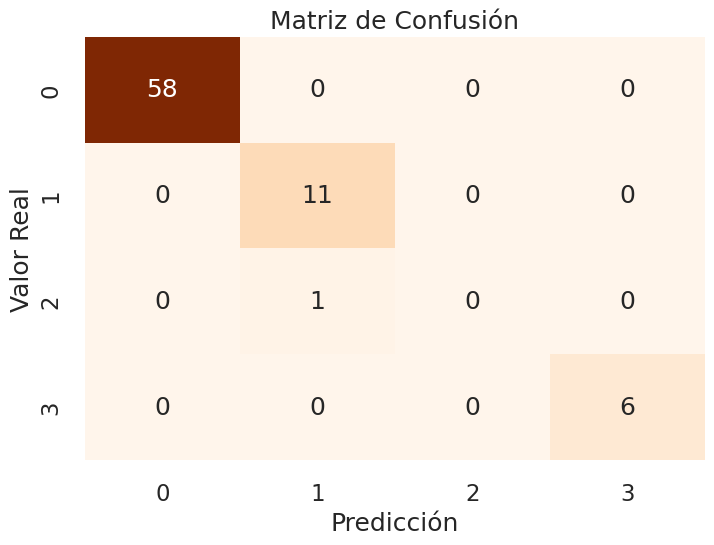

In [270]:
# Se visualiza con una matriz de confusión la calidad del modelo
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(pdf["CALIDAD"], pdf["categoria_estimada"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", cbar=False)
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión")
plt.show()


Se puede ver que para el valor 2 (muy_baja), el modelo no predijo correctamente un valor. Aparte de esto, el modelo acerto a la predicicon para el resto de valores.

#**Conclusión**
### Se realizaron los pasos necesarios para llevar a cabo un proyecto enfocado en la ciencia de datos. Cabe resaltar que este fue un ejemplo pequeño, ya que la cantidad de datos utilizados fue mínima. Sin embargo, este taller proporciona una guía clara y práctica que puede ser aplicada en proyectos más grandes y complejos.

# **Referencias**

* **[1]** Spellman FR. Handbook of Water and Wastewater Treatment Plant Operations. 3rd ed. Boca Raton: CRC Press; 2013.
* **[2]** Summer Kevin. [Water Quality](https://www.intechopen.com/chapters/69568). IntechOpen; DOI 978-1-78985-578-4.2020.
* **[3]** Hammer MJ. Water and Wastewater Technology. 7th ed. Upper Saddle River: Pearson education; 2011.
* **[4]** Tchobanoglous G, Burton FL, Stensel HD. Metcalf & Eddy Wastewater Engineering: Treatment and Reuse. 4th ed. New Delhi: Tata McGraw-Hill Limited; 2003.
* **[5]** Alley ER. Water Quality Control Handbook. Vol. 2. New York: McGraw-Hill; 2007.

* **[6]** Nathanson JA. Basic Environmental Technology: Water Supply. New Delhi: Printice-Hall of India; 2004

